<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Описание" data-toc-modified-id="Описание-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Описание</a></span></li><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Анализ</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Обучение</a></span></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Тестирование</a></span></li><li><span><a href="#Вывод" data-toc-modified-id="Вывод-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Вывод</a></span></li></ul></div>

#  Описание

Некий агрегатор такси собрал исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. 

Заказчик поручил разработать модель для предсказания количества заказов такси на следующий час. В качестве метрики была выбрана среднеквадратичная ошибка *RMSE*, показатель которой на тестовой выборке не должен быть больше 48.

## План работы

Для работы над данным проектом подготовим план работы:  
1. Загрузить имеющиеся данные, изучить их и подготовить для последующего анализа.  
2. Провести анализ данных. Проверить на нестационарность: тренд, сезонность, непостоянство дисперсии.  
3. Подобрать подходящую модель и определить её гиперпараметры.  
4. Прогнать модель на тестовой выборке.  
5. Сделать выводы.

<div class="toc"><ul class="toc-item"><li><span><a href="#Содержание" data-toc-modified-id="Содержание-1">Возврат к содержанию</a></span></li></ul></div>

## Подготовка

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import lightgbm as lgb

from sklearn.model_selection import train_test_split, GridSearchCV, TimeSeriesSplit, cross_val_score

from sklearn.metrics import mean_squared_error

from statsmodels.tsa.seasonal import seasonal_decompose

from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression

In [11]:
data = pd.read_csv('C:/Users/zmeis/datasets/taxi.csv', index_col=[0], parse_dates=[0])
data.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


In [12]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


ОК. Пропусков нет. Сейчас интервал равняется 10 минутам. Ресэмплируем данные по 1 часу, т.к. тако интервал выбрал заказчик. Так как мы рассматриваем количесвто заказов за определеенный период, то данные за новый полученный интервал необходимо суммировать.

In [13]:
data.sort_index(inplace=True)
data = data.resample('1H').sum()

<div class="alert alert-success" style="border-color: green; border-radius: 5px">
    <p><u><b>✅ КОММЕНТАРИЙ РЕВЬЮЕРА</b></u></p>ОК, данные на базе)

<div class="toc"><ul class="toc-item"><li><span><a href="#Содержание" data-toc-modified-id="Содержание-1">Возврат к содержанию</a></span></li></ul></div>

## Анализ

Посмотрим какие данные у нас получились после ресемпла.

In [14]:
data.describe()

,num_orders
count,4416.000000
mean,84.422781
std,45.023853
min,0.000000
25%,54.000000
50%,78.000000
75%,107.000000
max,462.000000


Интересно. Получается, что в среднем за час заказывает такси 84 человека. Но бывают часы когда заказов нет или же наоборот заказов аж 462.

In [15]:
print(data.index.is_monotonic)

True


ОК. Данные расположены в хронологическом порядке. Посмотрим на наличие сезонности и тренда, а также рассмотрим остаток.

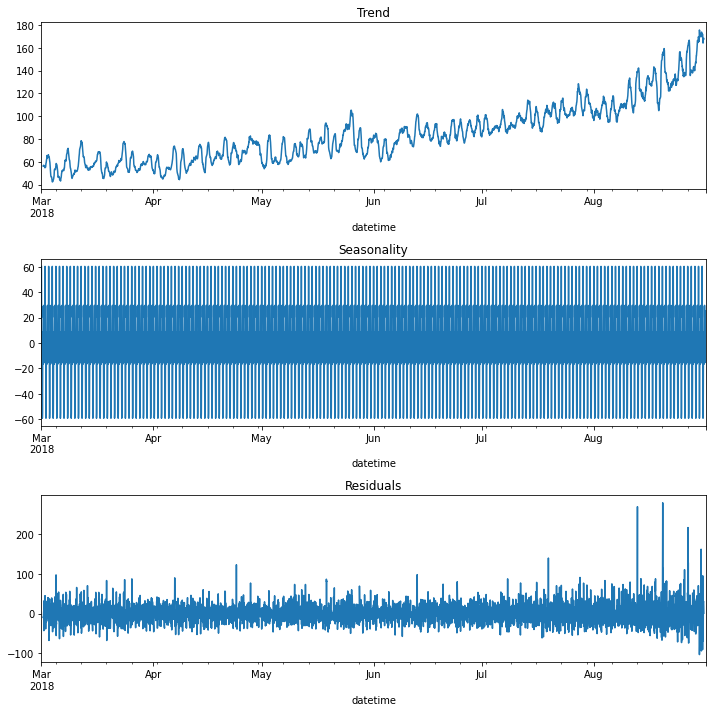

In [16]:
decomposed = seasonal_decompose(data)
plt.figure(figsize=(10, 10))
plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals')
plt.tight_layout()

Видно что есть и сезонность и тренд. Видно что количество заказов от марта к концу августа имеет тренд к росту. Для сезонности надо посмотреть укрупненно.

<AxesSubplot:xlabel='datetime'>

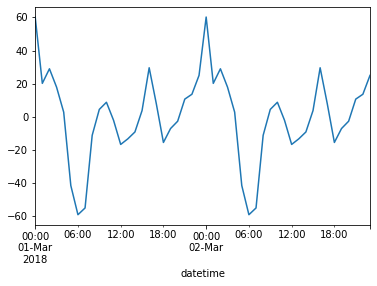

In [17]:
decomposed.seasonal['2018-03-01':'2018-03-02'].plot()

В данном случае количество заказов растет к полуночи и дальше снижается. Среднее количество заказов на протяжении всего трудового дня.

Добавим к уже имеющимся данным разности временного ряда, среднее и стандартное отклонения. Таким образом можно будет проверить данные на нестационарность. 

<ipython-input-18-db91c2170e0c>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_diff['num_orders'] = data_diff['num_orders'] - data_diff['num_orders'].shift()
<ipython-input-18-db91c2170e0c>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_diff['mean'] = data_diff['num_orders'].rolling(15).mean()
<ipython-input-18-db91c2170e0c>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in 

<AxesSubplot:xlabel='datetime'>

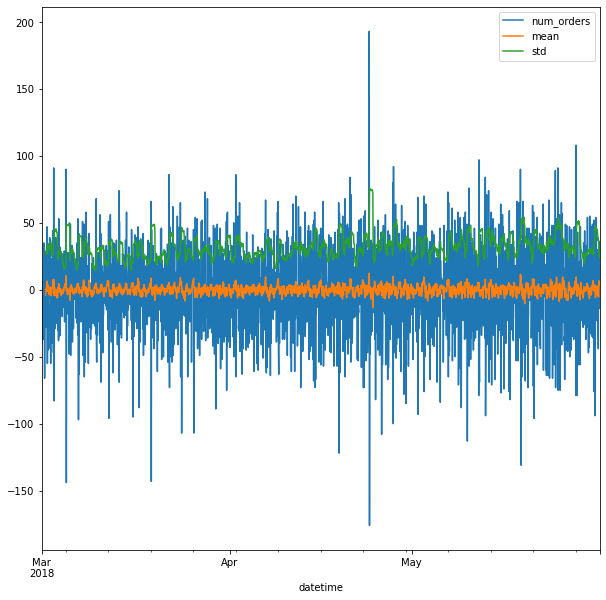

In [18]:
data_diff = data['2018-03':'2018-05']
data_diff['num_orders'] = data_diff['num_orders'] - data_diff['num_orders'].shift()
data_diff['mean'] = data_diff['num_orders'].rolling(15).mean()
data_diff['std'] = data_diff['num_orders'].rolling(15).std()
data_diff.plot(figsize=(10, 10))

Судя по полученному графику получившийся ряд нестационарный. С такими данными можно будет работать используя в качестве методов прогнозирования: линейную регрессию, дерево решений и градиентный бустинг.

<div class="toc"><ul class="toc-item"><li><span><a href="#Содержание" data-toc-modified-id="Содержание-1">Возврат к содержанию</a></span></li></ul></div>

## Обучение

С анализом закончили. Теперь стоит обучить несколько моделей. Как было определено раннее, будем использовать линейную регрессию, дерево решений и градиентный бустинг. Начнем с линейной регрессии.

Для кросс валидации временного ряда создадим переменную для TimeSeriesSplit, а размер тестовой выборки определим в 10%. Чтобы валидационная выборка примерно равнялась также 10%, подберем параметр n_splits.

In [20]:
test_size = 0.1
n_splits = int((1//0.1) - 1)
tscv = TimeSeriesSplit(max_train_size=None, n_splits=n_splits)

Создадим функцию для создания признаков

In [21]:
def make_features(data, max_lag, rolling_mean_size):
    data['hour'] = data.index.hour
    data['dayofweek'] = data.index.dayofweek
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    data['rolling_mean'] = data['num_orders'].shift(1).rolling(rolling_mean_size).mean()

В ходе перебора были определены следующие значения: лаг = 5, а скользящее среднее = 24 (т.е. среднее за сутки).

In [22]:
make_features(data, 5, 24)

И разделим выборку на обучающую и тестовую. Для последней оставим 10% данных.

In [23]:
train, test = train_test_split(data, shuffle=False, test_size=test_size)
train = train.dropna()

Выделим фичи и таргеты.

In [24]:
features_train = train.drop('num_orders', axis=1)
features_test = test.drop('num_orders', axis=1)
target_train = train['num_orders']
target_test = test['num_orders']

И приступаем к линейной регрессии:

In [26]:
model = LinearRegression().fit(features_train, target_train)
cross_val_score(model, features_train, target_train, cv=tscv, scoring='neg_root_mean_squared_error').mean()

-31.315888339943417

Можно перейти к дереву решений. Подберем гиперпараметры с помощью перебора GridSearchCV, который также позволяет проводить кросс-валидацию. В качестве гиперпараметров рассмотрим: максимальную глубину дерева от 1 до 10, минимальное количество образцов в листе в интервале от 1 до 8, минимальное количество образцов в узлах от 2 до 10.

In [27]:
parametrs = { 'max_depth': range (1,10, 2),
              'min_samples_leaf': range (1,8),
              'min_samples_split': range (2,10,2) }

In [28]:
model = DecisionTreeRegressor(random_state=12345)

In [29]:
grid = GridSearchCV(model, parametrs, cv=tscv, n_jobs=-1, scoring='neg_root_mean_squared_error')
grid.fit(features_train, target_train)
grid.best_params_

{'max_depth': 9, 'min_samples_leaf': 7, 'min_samples_split': 2}

In [31]:
model = DecisionTreeRegressor(max_depth=9, min_samples_leaf=7, min_samples_split=2, random_state=12345)
model.fit(features_train, target_train)
mean_squared_error(target_train, model.predict(features_train), squared=False)

20.578141493702066

Перейдем к градиентному бустингу

In [32]:
model = lgb.LGBMRegressor(random_state=12345)

В данном случае гиперпараметры перебирались вручную, т.к. GridSearchCV с этим справлялся очень долго.

In [34]:
model = lgb.LGBMRegressor(num_leaves=31, learning_rate=0.1, n_estimators=40, random_state=12345)
model.fit(features_train, target_train,
          eval_set=[(features_train, target_train)],
          eval_metric='rmse',
          verbose=10)
mean_squared_error(target_train, model.predict(features_train), squared=False)

[10]	training's rmse: 25.5316	training's l2: 651.86
[20]	training's rmse: 21.6815	training's l2: 470.089
[30]	training's rmse: 19.9517	training's l2: 398.072
[40]	training's rmse: 18.7933	training's l2: 353.189


d:\python\miniconda\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


18.793331612775262

| Модель    | Значение метрики RMSE
:-------- |:-----:
LinearRegression  | 31.3  
DecisionTreeRegressor      | 20.6    
LGBMRegressor      | 18.8     

Таким образом градиентный бустинг преобладает. Посмотрим на тестовых выборках

<div class="toc"><ul class="toc-item"><li><span><a href="#Содержание" data-toc-modified-id="Содержание-1">Возврат к содержанию</a></span></li></ul></div>

## Тестирование

Обучим модель еще раз, предскажем на тестовой выборке и проверим получившуюся метрику RMSE.

In [35]:
model = LinearRegression().fit(features_train, target_train)
cross_val_score(model, features_test, target_test, cv=tscv, scoring='neg_root_mean_squared_error').mean()

-53.95657420637716

In [36]:
model = DecisionTreeRegressor(max_depth=9, min_samples_leaf=7, min_samples_split=2, random_state=12345)
model.fit(features_train, target_train)
mean_squared_error(target_test, model.predict(features_test), squared=False)

50.754414977748965

In [37]:
model = lgb.LGBMRegressor(num_leaves=31, learning_rate=0.1, n_estimators=40, random_state=12345)
model.fit(features_train, target_train,
          eval_set=[(features_train, target_train)],
          eval_metric='rmse',
          verbose=10)
mean_squared_error(target_test, model.predict(features_test), squared=False)

[10]	training's rmse: 25.5316	training's l2: 651.86
[20]	training's rmse: 21.6815	training's l2: 470.089
[30]	training's rmse: 19.9517	training's l2: 398.072
[40]	training's rmse: 18.7933	training's l2: 353.189


d:\python\miniconda\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


46.80881004278981

| Модель    | Значение метрики RMSE
:-------- |:-----:
LinearRegression  | 53.9  
DecisionTreeRegressor      | 50.7    
LGBMRegressor      | 46.8     

Таким образом наиболее удачной моделью является градиентный бустинг. Для более наглядного примера рассмотрим расхождения предсказаний с фактом на графике.

<AxesSubplot:xlabel='Время заказа', ylabel='Количество заказов'>

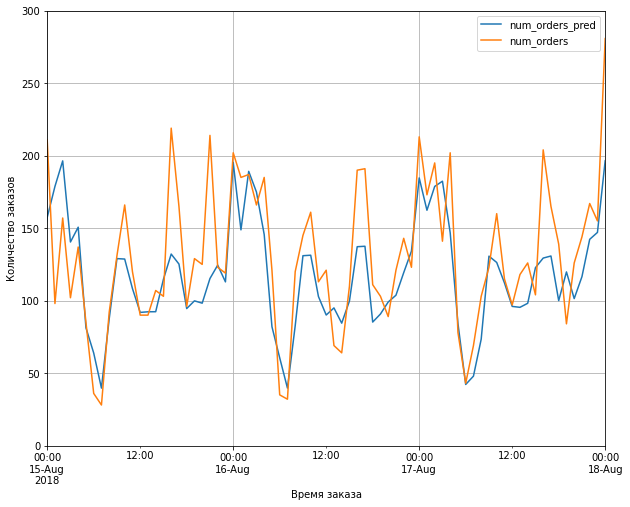

In [38]:
test['num_orders_pred'] = model.predict(features_test)
test[['num_orders_pred', 'num_orders']].plot(figsize=(10,8),
                                             grid=True,
                                             ylabel='Количество заказов',
                                             xlabel='Время заказа',
                                             xlim=[pd.Timestamp('2018-08-15'), pd.Timestamp('2018-08-18')],
                                             ylim=(0,300))

<AxesSubplot:xlabel='Время заказа', ylabel='Количество заказов'>

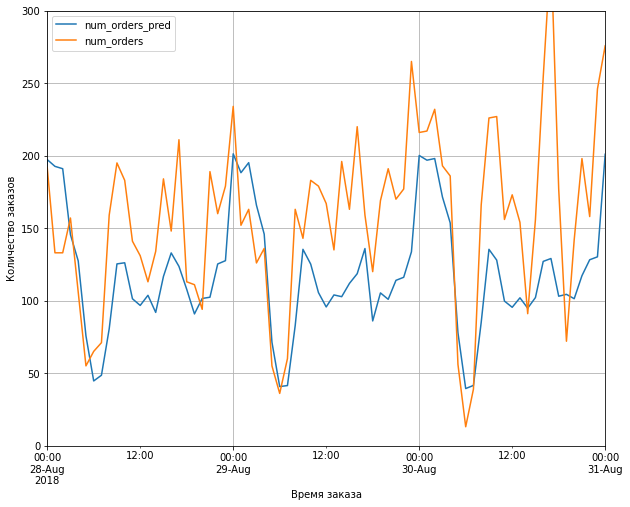

In [39]:
test[['num_orders_pred', 'num_orders']].plot(figsize=(10,8),
                                             grid=True,
                                             ylabel='Количество заказов',
                                             xlabel='Время заказа',
                                             xlim=[pd.Timestamp('2018-08-28'), pd.Timestamp('2018-08-31')],
                                             ylim=(0,300))

<div class="toc"><ul class="toc-item"><li><span><a href="#Содержание" data-toc-modified-id="Содержание-1">Возврат к содержанию</a></span></li></ul></div>

# Вывод

На графике выше видно, что к концу месяца расхождения начинают увеличиваться. Вероятно LGBM не самая подходящая модель и при прогнозе на более длительные сроки ошибка может расти. Для улучшения предсказаний моделе необходимо указать на причины, по которым происходит колебания временного ряда. Одного количества заказов недостаточно, т.к. на колебания может влиять, например, количество такси на линии, акционные продажи, погодные условия и прочее. В связи с тем, что таких данных получить от заказчика не получится, остановимся на LGBM. К тому же, т.к. горизонт прогноза составляет следующий час, то предсказания будут достаточно точными.

<div class="toc"><ul class="toc-item"><li><span><a href="#Содержание" data-toc-modified-id="Содержание-1">Возврат к содержанию</a></span></li></ul></div>